In [ ]:
from typing import TypedDict, List, Dict
from langgraph.graph import StateGraph, START, END 
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

class State(TypedDict):
    dish: str
    ingredients: list[dict]
    recipe_steps: str
    plating_instructions: str

class Ingredient(BaseModel):
    name: str
    quantity: str
    unit: str

class IngredientsOutput(BaseModel):
    ingredients: List[Ingredient]

llm = init_chat_model("openai:gpt-4o-mini")

In [7]:
def list_ingredients(state: State):
    dish = state["dish"]

    prompt = f"다음 요리의 재료들을 알려주세요. 요리: {dish}"

    structured_llm = llm.with_structured_output(IngredientsOutput)

    response = structured_llm.invoke(prompt)

    return {"ingredients": response}

def create_recipe(state: State):
    ingredients = state["ingredients"]
    dish = state["dish"]

    prompt = f"요리와 재료를 보고 조리법을 순서대로 알려주세요. 요리: {dish} 재료: {ingredients}"

    response = llm.invoke(prompt)

    return {"recipe_steps": response.content}

def describe_plating(state: State):
    dish = state["dish"]
    recipe_steps = state["recipe_steps"]

    prompt = f"다음 요리와 조리법을 보고 예쁘게 플레이팅을 하는 방법을 가르쳐 주세요. 요리:{dish} 조리법:{recipe_steps}"

    response = llm.invoke(prompt)

    return {"plating_instructions": response.content}

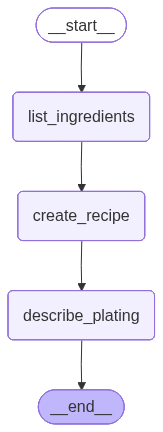

In [8]:
graph_builder = StateGraph(State)

graph_builder.add_node("list_ingredients", list_ingredients)
graph_builder.add_node("create_recipe", create_recipe)
graph_builder.add_node("describe_plating", describe_plating)

graph_builder.add_edge(START, "list_ingredients")
graph_builder.add_edge("list_ingredients", "create_recipe")
graph_builder.add_edge("create_recipe", "describe_plating")
graph_builder.add_edge("describe_plating", END)

graph = graph_builder.compile()
graph

In [9]:
graph.invoke(
    {
        "dish": "계란찜"
    }
)

{'ingredients': IngredientsOutput(ingredients=[Ingredient(name='계란', quantity='3', unit='개'), Ingredient(name='물', quantity='1', unit='컵'), Ingredient(name='소금', quantity='1/2', unit='티스푼'), Ingredient(name='간장', quantity='1', unit='티스푼'), Ingredient(name='파', quantity='1', unit='큰술'), Ingredient(name='후추', quantity='약간', unit='티스푼')]),
 'dish': '계란찜',
 'recipe_steps': '계란찜의 조리법을 순서대로 알려드리겠습니다.\n\n### 재료\n- 계란: 3개\n- 물: 1컵\n- 소금: 1/2 티스푼\n- 간장: 1 티스푼\n- 파: 1 큰술 (다진 것)\n- 후추: 약간\n\n### 조리법\n1. **재료 준비**: 계란을 깨서 그릇에 담고, 물, 소금, 간장을 넣습니다.\n   \n2. **혼합**: 계란과 다른 재료들을 잘 섞어줍니다. 흰자와 노른자가 골고루 섞일 수 있도록 저어주세요.\n\n3. **거품 제거**: 혼합한 계란 물 위에 생긴 거품을 숟가락으로 제거합니다. 이는 더 부드러운 식감을 위해 중요합니다.\n\n4. **증기 조리 준비**: 준비된 계란 혼합물을 체로 한번 걸러 냄으로써 공기 방울과 입자를 제거하여 부드럽고 균일한 질감을 만듭니다.\n\n5. **찜기 설정**: 찜기에 계란 혼합물이 담긴 그릇을 넣고, 물을 적당히 부어 찜을 시작합니다. \n   - 물이 끓기 전에 찜 시작.\n\n6. **중약불에서 찌기**: 중약불에서 약 15-20분 정도 찌도록 합니다. 찜기를 덮고 너무 많이 열지 말고, 중간중간 확인하세요. \n\n7. **다진 파와 후추 추가**: 계란찜이 거의 다 익었을 때, 다진 파와 후추를 뿌려줍니다. \n\n8. **완성**: 계란찜이